<a href="https://colab.research.google.com/drive/1QpZVVF_j3pEp_XqewGPzdFLaTbgzF2Gk?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

# PROBLEM SET 1 (50 points)

### PS1.A (15 points)
![](images/autoencoder.png)
Design a neural system that will receive an input image from the CIFAR10 dataset and it will _reconstruct it_ at the output.

To do so the encoder must compress the input image into a vector of size $d$ and the decoder must reconstruct the image from the vector of size $d$.

The encoder spatial dimensions of its output feature maps will determined by the input height or width (i), kernel (k), padding (p), and stride (s), producing the output feature map (o) size that is given by

$$o = \frac{i-k+2p}{s}+1$$

The decoder must make use of a number of _transposed convolutional_ layers - each successively upsamples its input feature map. The operation is the inverse of the earlier question on representing convolution as a matrix by vector product:

$$x = C^T y$$

For a given size of the input (i), kernel (k), padding (p), and stride (s), the size of the output feature map (o) generated is given by

$$o = s(i-1)+k-2p$$

Ultimately the size of the input image is produced at the output of the decoder and this would allow the comparison of the original input image and the decoded image $\tilde x$.  

Your design should include all dimensions of the encoder and decoder CNNs including the number of layers, number of filters and spatial dimensions, the activation functions, the loss function, the optimizer. You need to expose this information via the API (you can use any framework you know).



In [ ]:
# Python model of the autoencoder

# Importing libraries

import numpy as np
import matplotlib.pyplot as plt
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, Conv2DTranspose, Activation, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, LearningRateScheduler
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import regularizers

In [ ]:
# Load the CIFAR10 dataset having shape of [32, 32, 3]. Rescaling data to [0, 1] by dividing with 255.

(train_data_clean, _), (test_data_clean, _) = cifar10.load_data()

# Scaling input data

train_data_clean = train_data_clean.astype('float32') / 255.
test_data_clean = test_data_clean.astype('float32') / 255.

170498071/170498071 [==============================] - 6s 0us/step


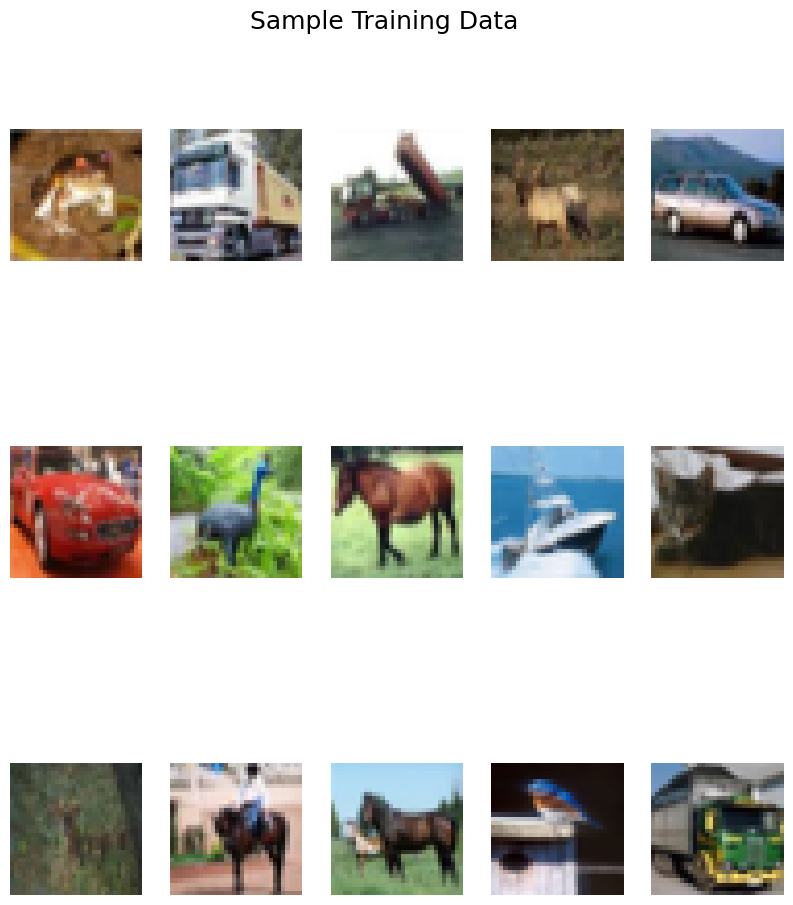

In [ ]:
# Visualizing Clean Images

rows = 3 # Number of rows in figure
cols = 5 # Number of colums in figure

f = plt.figure(figsize = (2 * cols, 2 * rows * 2)) # Defining a figure

for i in range(rows):
    for j in range(cols):
        f.add_subplot(rows * 2, cols, (2 * i * cols) + (j + 1))
        plt.imshow(train_data_clean[i * cols + j])
        plt.axis("off")

f.suptitle("Sample Training Data", fontsize = 18)
plt.savefig("Cifar-trian.png")

plt.show()

In [ ]:
# Building a CNN Autoencoder Network

# Convolutional blocks consist of 3 operations: 2D convolution, batch normalization and ReLu activation. We use strides=2 to downsample data going through the network.

def conv_block(x, filters, kernel_size, strides = 2):
    x = Conv2D(filters = filters,
               kernel_size = kernel_size,
               strides = strides,
               padding = 'same',
               activation = 'relu',
               kernel_regularizer = regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    return x

# Deconvolutional blocks also consist of 3 operations: 2D transposed convolution, batch normalization and also ReLu activation. Here strides=2 is used to upsample the data.

def deconv_block(x, filters, kernel_size):
    x = Conv2DTranspose(filters = filters,
                        kernel_size = kernel_size,
                        strides = 2,
                        padding = 'same',
                        activation = 'relu',
                        kernel_regularizer = regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    return x

In [ ]:
# 5 convolutional blocks with downsampling
# 1 convolutional block without downsampling
# 5 deconvolutional blocks with upsampling, interleaving concatenations
# 1 final deconvolution that recreates image size (32, 32, 3)
# 1 activation layer with sigmoid that scales values to 0-1.

def autoencoder():
    inputs = Input(shape = (32, 32, 3), name = 'inputs')
    conv_block1 = conv_block(inputs, 32, 3)
    conv_block2 = conv_block(conv_block1, 64, 3)
    conv_block3 = conv_block(conv_block2, 128, 3)
    conv_block4 = conv_block(conv_block3, 256, 3)
    conv_block5 = conv_block(conv_block4, 256, 3)
    conv_block6 = conv_block(conv_block5, 512, 3, 1)

    deconv_block1 = deconv_block(conv_block6, 512, 3)
    merge1 = Concatenate()([deconv_block1, conv_block4])
    deconv_block2 = deconv_block(merge1, 256, 3)
    merge2 = Concatenate()([deconv_block2, conv_block3])
    deconv_block3 = deconv_block(merge2, 128, 3)
    merge3 = Concatenate()([deconv_block3, conv_block2])
    deconv_block4 = deconv_block(merge3, 64, 3)
    merge4 = Concatenate()([deconv_block4, conv_block1])
    deconv_block5 = deconv_block(merge4, 32, 3)

    final_deconv = Conv2DTranspose(filters = 3, kernel_size = 3, padding = 'same')(deconv_block5)
    outputs = Activation('sigmoid', name = 'output')(final_deconv)
    return Model(inputs, outputs, name = 'autoencoder')

In [ ]:
model = autoencoder()

def scheduler(epoch):
    if epoch < 10:
        return 0.0001
    else:
        return 0.0001 * tf.math.exp(0.1 * (10 - epoch))

class myCallback(Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if(logs.get('accuracy') > 0.80):
            print("\nReached 80% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

lr = LearningRateScheduler(scheduler)
checkpoint = ModelCheckpoint('best_model.h5', verbose = 1, save_best_only = True, save_weights_only = True)

model.compile(optimizer = "adam", loss = 'mse', metrics=["accuracy"])
model.summary()

Model: "autoencoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 32)   896         ['inputs[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 8, 64)     18496       ['batch_normalization[0

### PS1.B (15 points)

Train your PS1.A autoencoder  and produce the validation or test loss as a number of epochs. Make sure you explain any preprocessing stages and ensure you show the hyperparameter tuning process in your code.



In [ ]:
# Training code for the autoencoder and the code for the prediction of the test set

# Training

history = model.fit(train_data_clean,
                    train_data_clean,
                    validation_data = (test_data_clean, test_data_clean),
                    epochs = 10,
                    batch_size = 128,
                    shuffle = True,
                    callbacks = [checkpoint, callbacks, lr])

Epoch 1/10
391/391 [==============================] - ETA: 0s - loss: 0.0164 - accuracy: 0.7885
Epoch 1: val_loss improved from 0.10860 to 0.01079, saving model to best_model.h5
391/391 [==============================] - 1682s 4s/step - loss: 0.0164 - accuracy: 0.7885 - val_loss: 0.0108 - val_accuracy: 0.8096 - lr: 1.0000e-04
Epoch 2/10
391/391 [==============================] - ETA: 0s - loss: 0.0062 - accuracy: 0.8303
Epoch 2: val_loss improved from 0.01079 to 0.00584, saving model to best_model.h5

Reached 80% accuracy so cancelling training!
391/391 [==============================] - 1678s 4s/step - loss: 0.0062 - accuracy: 0.8303 - val_loss: 0.0058 - val_accuracy: 0.7987 - lr: 1.0000e-04


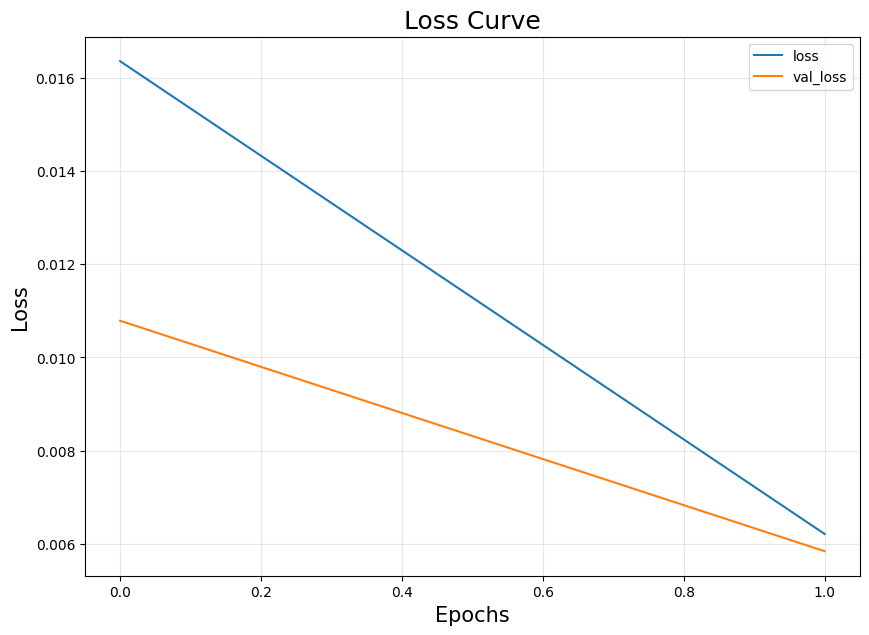

In [ ]:
# Defining Figure

f = plt.figure(figsize=(10,7))
f.add_subplot()

# Adding Subplot

plt.plot(history.epoch, history.history['loss'], label = "loss") # Loss curve for training set
plt.plot(history.epoch, history.history['val_loss'], label = "val_loss") # Loss curve for validation set

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
plt.savefig("Loss_curve_cifar10.png")
plt.show()

In [ ]:
# Testing by selecting few random test images

num_imgs = 48
rand = np.random.randint(1, test_data_clean.shape[0]-48)

cifar_test_images = test_data_clean[rand:rand+num_imgs] # Slicing
cifar_test_predicted = model.predict(cifar_test_images) # Predict

2/2 [==============================] - 2s 317ms/step


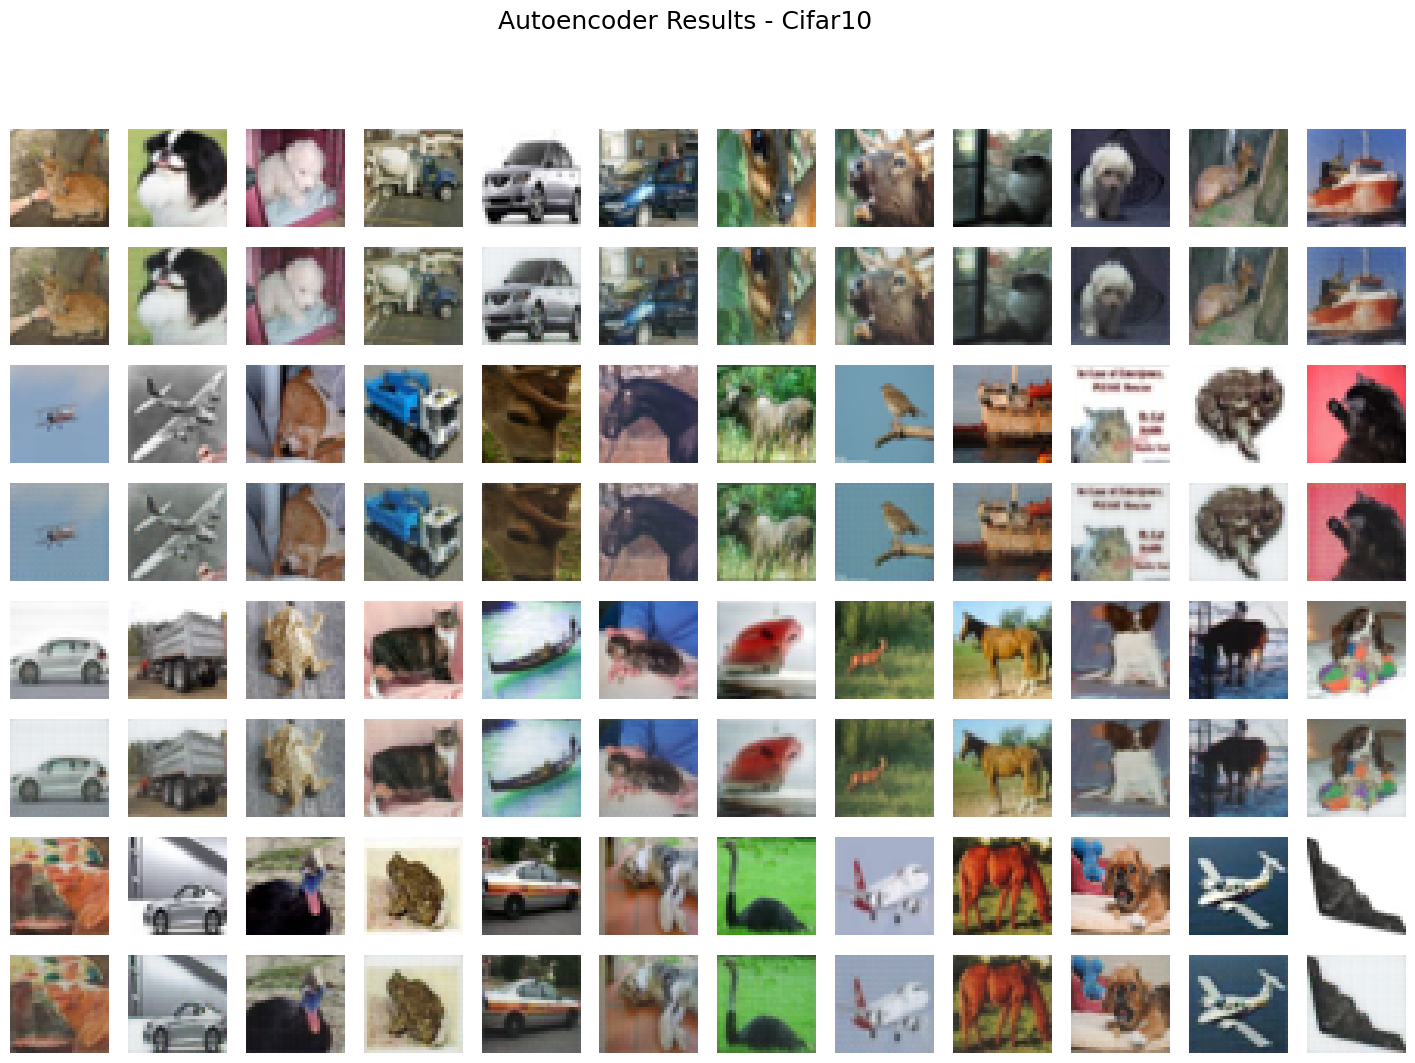

In [ ]:
rows = 4 # Defining number of rows in figure
cols = 12 # Defining number of colums in figure
cell_size = 1.5
f = plt.figure(figsize=(cell_size*cols,cell_size*rows*2)) # Defining a figure
f.tight_layout()

for i in range(rows):
    for j in range(cols):
        f.add_subplot(rows * 2, cols, (2 * i * cols) + (j + 1)) # Adding sub plot to figure on each iteration
        plt.imshow(cifar_test_images[i * cols + j])
        plt.axis("off")

    for j in range(cols):
        f.add_subplot(rows * 2, cols, ((2 * i+ 1) * cols) + (j + 1)) # Adding sub plot to figure on each iteration
        plt.imshow(cifar_test_predicted[i * cols + j])
        plt.axis("off")

f.suptitle("Autoencoder Results - Cifar10",fontsize=18)
plt.savefig("test_results_cifar10.png")

plt.show()

### PS1.C (20 points)

Add zero-mean Gaussian noise with variance that ranges from 0 to 1 to the images and repeat the training exercise comparing results with PS1.B and explaining why adding noise is a good idea.

In [ ]:
# To add noise we can generate array with same dimension of our images with random values between [0,1] using normal distribution
# with mean = 0 and standard deviation = 0.3. To generate normal distribution, we can use np.random.normal(loc,scale,size).
# Then scale the noise by some factor, here I am using 0.3. After adding noise, pixel values can be out of range [0,1],
# so we need to clip the values using np.clip(arr, arr_min, arr_max ).

def add_noise_and_clip_data(data):
    noise = np.random.normal(loc = 0.0, scale = 0.3, size = data.shape)
    data = data + noise * 0.3
    data = np.clip(data, 0., 1.)
    return data

train_data_noisy = add_noise_and_clip_data(train_data_clean)
test_data_noisy = add_noise_and_clip_data(test_data_clean)

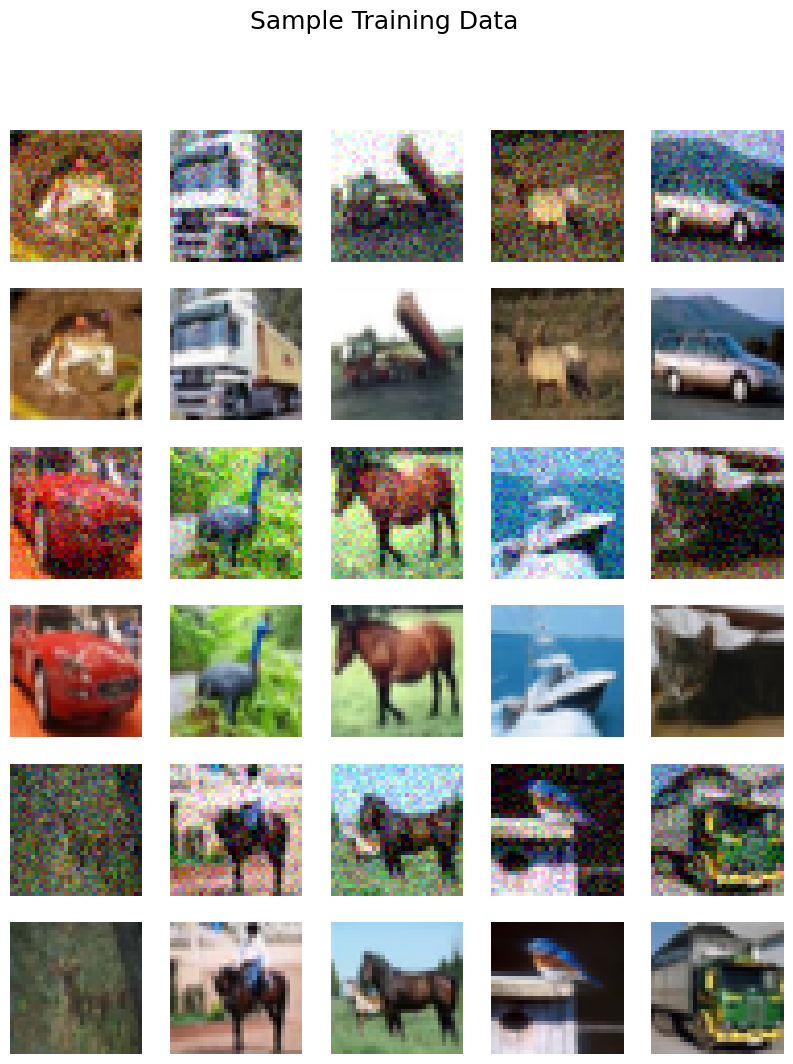

In [ ]:
# Visualizing Noisy Images

rows = 3 # Number of rows in figure
cols = 5 # Number of colums in figure

f = plt.figure(figsize = (2 * cols, 2 * rows * 2)) # Defining a figure

for i in range(rows):
    for j in range(cols):
        f.add_subplot(rows * 2, cols, (2 * i * cols) + (j + 1)) # Adding sub plot to figure on each iteration
        plt.imshow(train_data_noisy[i * cols + j])
        plt.axis("off")

    for j in range(cols):
        f.add_subplot(rows * 2, cols, ((2 * i + 1) * cols) + (j + 1)) # Adding sub plot to figure on each iteration
        plt.imshow(train_data_clean[i * cols + j])
        plt.axis("off")

f.suptitle("Sample Training Data", fontsize = 18)
plt.savefig("Cifar-trian.png")

plt.show()

In [ ]:
# Training

history = model.fit(train_data_noisy,
                    train_data_clean,
                    validation_data = (test_data_noisy, test_data_clean),
                    epochs = 10,
                    batch_size = 128,
                    shuffle = True,
                    callbacks = [checkpoint, callbacks, lr])

Epoch 1/10
391/391 [==============================] - ETA: 0s - loss: 0.0050 - accuracy: 0.7593
Epoch 1: val_loss improved from 0.00584 to 0.00522, saving model to best_model.h5
391/391 [==============================] - 1678s 4s/step - loss: 0.0050 - accuracy: 0.7593 - val_loss: 0.0052 - val_accuracy: 0.7561 - lr: 1.0000e-04
Epoch 2/10
391/391 [==============================] - ETA: 0s - loss: 0.0041 - accuracy: 0.7693
Epoch 2: val_loss improved from 0.00522 to 0.00502, saving model to best_model.h5
391/391 [==============================] - 1673s 4s/step - loss: 0.0041 - accuracy: 0.7693 - val_loss: 0.0050 - val_accuracy: 0.7665 - lr: 1.0000e-04
Epoch 3/10
391/391 [==============================] - ETA: 0s - loss: 0.0032 - accuracy: 0.7761
Epoch 3: val_loss improved from 0.00502 to 0.00453, saving model to best_model.h5
391/391 [==============================] - 1668s 4s/step - loss: 0.0032 - accuracy: 0.7761 - val_loss: 0.0045 - val_accuracy: 0.7676 - lr: 1.0000e-04
Epoch 4/10
391/3

In [ ]:
# Defining Figure

f = plt.figure(figsize=(10,7))
f.add_subplot()

# Adding Subplot

plt.plot(history.epoch, history.history['loss'], label = "loss") # Loss curve for training set
plt.plot(history.epoch, history.history['val_loss'], label = "val_loss") # Loss curve for validation set

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
plt.savefig("Loss_curve_cifar10.png")
plt.show()

In [ ]:
# Testing by selecting few random test images

num_imgs = 48
rand = np.random.randint(1, test_data_noisy.shape[0]-48)

cifar_test_images = test_data_noisy[rand:rand+num_imgs] # Slicing
cifar_test_predicted = model.predict(cifar_test_images) # Predict

2/2 [==============================] - 1s 381ms/step


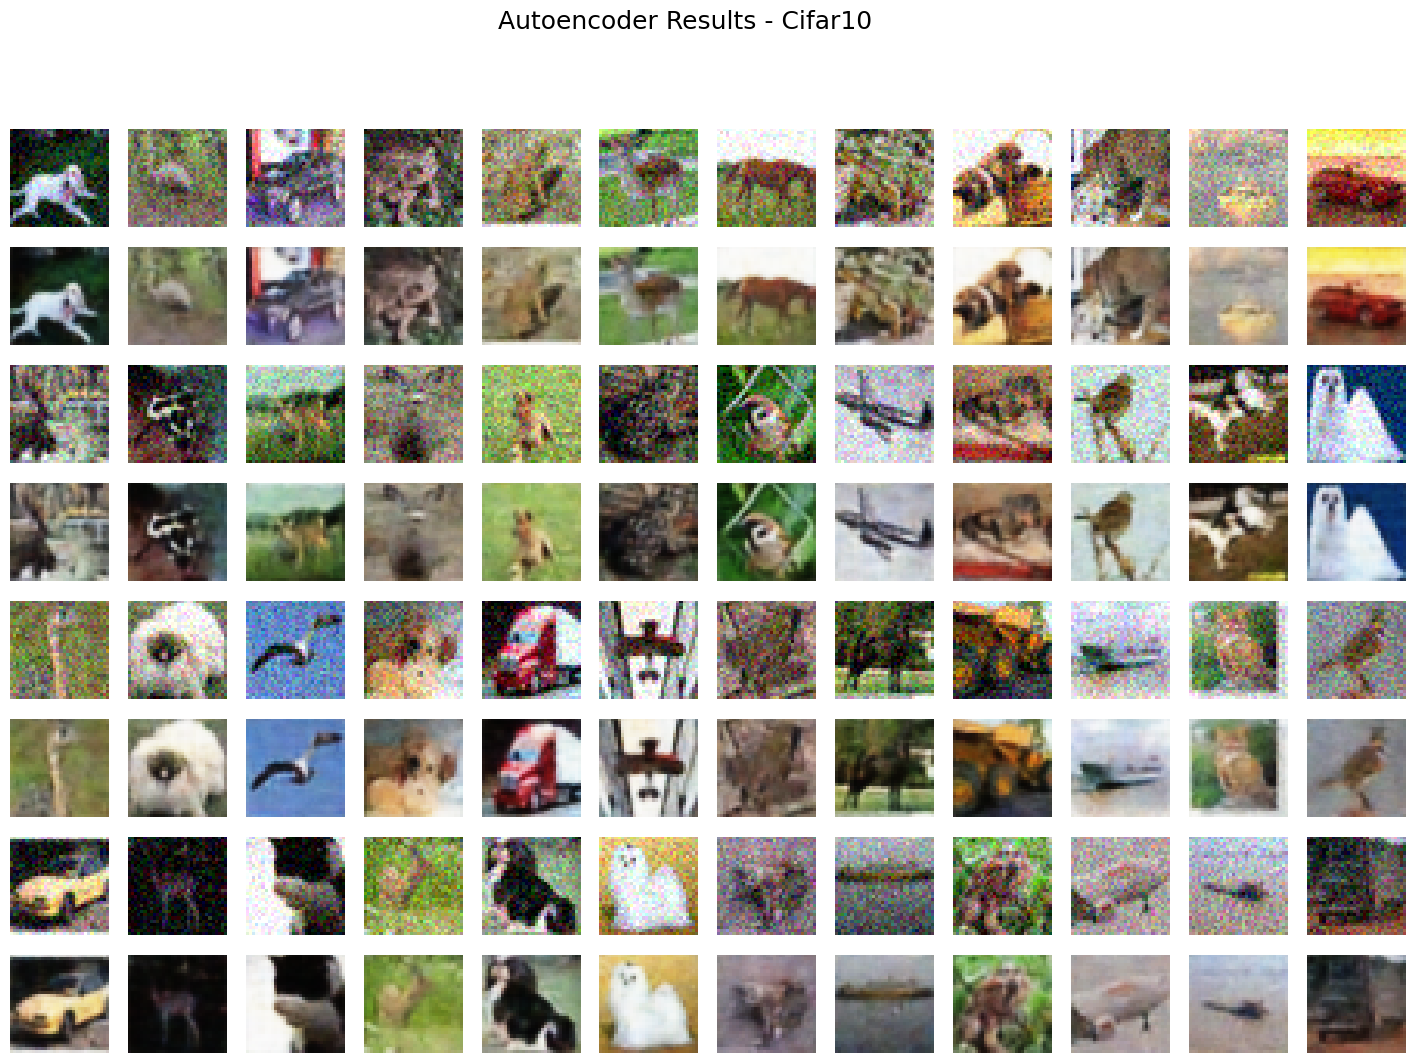

In [ ]:
rows = 4 # Defining number of rows in figure
cols = 12 # Defining number of colums in figure
cell_size = 1.5
f = plt.figure(figsize=(cell_size*cols,cell_size*rows*2)) # Defining a figure
f.tight_layout()
for i in range(rows):
    for j in range(cols):
        f.add_subplot(rows * 2, cols, (2 * i * cols) + (j + 1)) # Adding sub plot to figure on each iteration
        plt.imshow(cifar_test_images[i * cols + j])
        plt.axis("off")

    for j in range(cols):
        f.add_subplot(rows * 2, cols, ((2 * i+ 1) * cols) + (j + 1)) # Adding sub plot to figure on each iteration
        plt.imshow(cifar_test_predicted[i * cols + j])
        plt.axis("off")

f.suptitle("Autoencoder Results - Cifar10",fontsize=18)
plt.savefig("test_results_cifar10.png")

plt.show()

Why adding noise to Denoising Autoencoder?

To develop a generalized model, a bit of noise is added to the input data to make it corrupt. The uncorrupted data is maintained, and it acts as the output. Here the model cannot memorize the training data and maps out the result as input. Output targets are different. This forces the model to map the input data to a lower-dimension manifold (a concentration point for input data). Consider an example where the data is comprised of car images; all images that look like cars would be part of a manifold. If this manifold is accurately detected then the added noise can be skipped.